In [3]:
import os
import sys

import matplotlib.pyplot as plt

module_path = os.path.abspath(os.path.join('..'))
sys.path.append(module_path)

import numpy as np
import pandas as pd
from sklearn.metrics import r2_score
from sklearn.model_selection import train_test_split
import xgboost as xgb

from sklearn.base import BaseEstimator,TransformerMixin, ClassifierMixin
from sklearn.utils import check_array
from sklearn.pipeline import make_pipeline
from tpot.builtins import ZeroCount

import warnings
warnings.filterwarnings('ignore')

# my own module
from conf.configure import Configure
from utils import data_util
from CV import DeepCV, PrintImportance, StackingEstimator

In [2]:
import numpy as np
import pandas as pd
import datetime
from sklearn.cross_validation import KFold
from sklearn.cross_validation import train_test_split
import time
%matplotlib inline
from sklearn import preprocessing
from sklearn.preprocessing import Imputer
from xgboost import XGBRegressor
from sklearn.ensemble import RandomForestRegressor, ExtraTreesRegressor, GradientBoostingRegressor
from sklearn.grid_search import GridSearchCV
from sklearn.cross_validation import ShuffleSplit
from sklearn.metrics import make_scorer, mean_squared_error, r2_score
from sklearn.linear_model import Ridge, LassoCV,LassoLarsCV, ElasticNet, Lasso
from sklearn.kernel_ridge import KernelRidge
from sklearn.neighbors import KNeighborsRegressor
from sklearn.svm import SVR
from scipy.stats import skew
from time import time

R2 = make_scorer(r2_score, greater_is_better=True)

In [3]:
print 'load datas...'
train, test = data_util.load_dataset()

y_train_all = train['y']
del train['ID']
del train['y']
id_test = test['ID']
del test['ID']

load datas...


In [4]:
X_train = train
X_test = test
y_train = y_train_all
y_mean = np.mean(y_train)
del train, test, y_train_all

In [5]:
class StackingEstimator(BaseEstimator, TransformerMixin):
    
    def __init__(self, estimator):
        self.estimator = estimator

    def fit(self, X, y=None, **fit_params):
        self.estimator.fit(X, y, **fit_params)
        return self
    def transform(self, X):
        X = check_array(X)
        X_transformed = np.copy(X)
        # add class probabilities as a synthetic feature
        if issubclass(self.estimator.__class__, ClassifierMixin) and hasattr(self.estimator, 'predict_proba'):
            X_transformed = np.hstack((self.estimator.predict_proba(X), X))

        # add class prodiction as a synthetic feature
        X_transformed = np.hstack((np.reshape(self.estimator.predict(X), (-1, 1)), X_transformed))

        return X_transformed

In [5]:
xgb_params = {'n_trees': 520,     
              'learning_rate': 0.0045,    
              'max_depth': 4,    
              'subsample': 0.94,    
              'objective': 'reg:linear',    
              'eval_metric': 'rmse',    
              'base_score': y_mean, 
              # base prediction = mean(target)   
              'silent': 1,   
              'seed':5}

dtrain = xgb.DMatrix(X_train, y_train)
dtest = xgb.DMatrix(X_test)

cv_output = xgb.cv(xgb_params, dtrain, num_boost_round=1000, early_stopping_rounds=50,\
    verbose_eval=50, show_stdv=False)
cv_output[['train-rmse-mean', 'test-rmse-mean']].plot()

dtrain = xgb.DMatrix(X_train, y_train)
dtest = xgb.DMatrix(X_test)

num_boost_rounds = len(cv_output)
model = xgb.train(dict(xgb_params, silent=0), dtrain, num_boost_round=num_boost_rounds)

y_predict = model.predict(dtest)

[0]	train-rmse:12.6436	test-rmse:12.6422
[50]	train-rmse:11.2078	test-rmse:11.2823
[100]	train-rmse:10.1532	test-rmse:10.3228
[150]	train-rmse:9.39228	test-rmse:9.66048
[200]	train-rmse:8.85076	test-rmse:9.21386
[250]	train-rmse:8.45328	test-rmse:8.91647
[300]	train-rmse:8.1582	test-rmse:8.72149
[350]	train-rmse:7.92792	test-rmse:8.59791
[400]	train-rmse:7.73743	test-rmse:8.52228
[450]	train-rmse:7.5815	test-rmse:8.4729
[500]	train-rmse:7.44742	test-rmse:8.44181
[550]	train-rmse:7.33742	test-rmse:8.42149
[600]	train-rmse:7.23831	test-rmse:8.41179
[650]	train-rmse:7.14354	test-rmse:8.40683
[700]	train-rmse:7.06218	test-rmse:8.40239
[750]	train-rmse:6.99119	test-rmse:8.40026


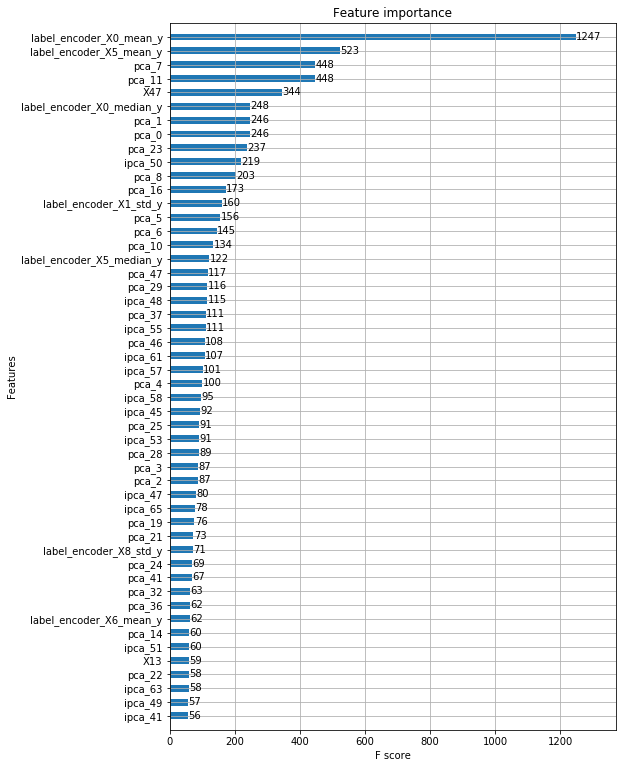

In [9]:
fig, ax = plt.subplots(1, 1, figsize=(8, 13))
xgb.plot_importance(model, max_num_features=50, height=0.5, ax=ax)

In [12]:
xgb_params = {'learning_rate': 0.005,
              'max_depth': 4,
              'subsample': 0.95,
              'objective': 'reg:linear',
              #'eval_metric': 'rmse',
              'silent': 1,
              'reg_alpha': 0,
              'min_child_weight':4,
              'colsample_bytree': 0.95,
              'gamma':.4,
              #'booster' :'gbtree',
              #'tuneLength': 3,
              'seed': 5 }
#print(len(cv_output)) #309

xgb_params['n_estimators']=616 #len(cv_output)

model = XGBRegressor(**xgb_params)
model.fit(X_train, y_train)
y_predict = model.predict(X_test)

GradientBoostingModel

In [10]:
model = GradientBoostingRegressor(learning_rate=0.001, loss="huber", max_depth=3, max_features=0.55, random_state=5,
                                  min_samples_leaf=18, min_samples_split=14, subsample=0.7)
model.fit(X_train, y_train)
y_predict = model.predict(X_test)

In [5]:
model = Lasso(alpha=0.01)
DeepCV(metric=r2_score, model=model, train=X_train, y_train_all=y_train)
model.fit(X_train, y_train)
y_predict = model.predict(X_test)

perform 1 cross-validate: train r2 score = 0.599411309554, validate r2 score = 0.594966272774
perform 2 cross-validate: train r2 score = 0.605417590037, validate r2 score = 0.571949961404
perform 3 cross-validate: train r2 score = 0.612810000065, validate r2 score = 0.545784895931
perform 4 cross-validate: train r2 score = 0.589413539307, validate r2 score = 0.622454596188
perform 5 cross-validate: train r2 score = 0.634046200712, validate r2 score = 0.503352083397

average train r2 score = 0.608219727935, average validate r2 score = 0.567701561939


In [7]:
model = Ridge(alpha=0.5)
DeepCV(metric=r2_score, model=model, train=X_train, y_train_all=y_train)
model.fit(X_train, y_train)
y_predict = model.predict(X_test)

perform 1 cross-validate: train r2 score = 0.620636440004, validate r2 score = 0.573103128243
perform 2 cross-validate: train r2 score = 0.62562360401, validate r2 score = 0.553131752592
perform 3 cross-validate: train r2 score = 0.633655041047, validate r2 score = 0.523035255291
perform 4 cross-validate: train r2 score = 0.609964181296, validate r2 score = 0.600453739948
perform 5 cross-validate: train r2 score = 0.65123687171, validate r2 score = 0.496159511777

average train r2 score = 0.628223227613, average validate r2 score = 0.54917667757


In [7]:
exported_pipeline = make_pipeline(
    ZeroCount(),
    LassoLarsCV(normalize=True)
)
DeepCV(metric=r2_score, model=exported_pipeline, train=X_train, y_train_all=y_train)
exported_pipeline.fit(X_train, y_train)
y_predict = exported_pipeline.predict(X_test)

perform 1 cross-validate: train r2 score = 0.574843814244, validate r2 score = 0.608943475272
perform 2 cross-validate: train r2 score = 0.589844014743, validate r2 score = 0.580841875446
perform 3 cross-validate: train r2 score = 0.590698445684, validate r2 score = 0.55929223719
perform 4 cross-validate: train r2 score = 0.568350712599, validate r2 score = 0.644508719835
perform 5 cross-validate: train r2 score = 0.614481834078, validate r2 score = 0.511268777283
perform 6 cross-validate: train r2 score = 0.570729910852, validate r2 score = 0.639038744957
perform 7 cross-validate: train r2 score = 0.561149053994, validate r2 score = 0.650203955136
perform 8 cross-validate: train r2 score = 0.573302513501, validate r2 score = 0.625927274037
perform 9 cross-validate: train r2 score = 0.577702558806, validate r2 score = 0.604072706463
perform 10 cross-validate: train r2 score = 0.609614023193, validate r2 score = 0.510453450925

average train r2 score = 0.583071688169, average validate r

In [9]:
model = make_pipeline(
    StackingEstimator(estimator=LassoLarsCV(normalize=True)),
    StackingEstimator(estimator=GradientBoostingRegressor(learning_rate=0.001, loss="huber", max_depth=3, max_features=0.55, min_samples_leaf=18, min_samples_split=14, subsample=0.7)),
    LassoLarsCV()
)
DeepCV(metric=r2_score, model=model, train=X_train, y_train_all=y_train)
model.fit(X_train, y_train)
y_predict = model.predict(X_test)

perform 1 cross-validate: train r2 score = 0.579641990182, validate r2 score = 0.592406467318
perform 2 cross-validate: train r2 score = 0.589392945411, validate r2 score = 0.580201616619
perform 3 cross-validate: train r2 score = 0.59466134948, validate r2 score = 0.558877007502
perform 4 cross-validate: train r2 score = 0.570195253186, validate r2 score = 0.635688167531
perform 5 cross-validate: train r2 score = 0.618940758704, validate r2 score = 0.49655740488
perform 6 cross-validate: train r2 score = 0.57253508886, validate r2 score = 0.6355387442
perform 7 cross-validate: train r2 score = 0.566914353828, validate r2 score = 0.651296242157
perform 8 cross-validate: train r2 score = 0.576011288655, validate r2 score = 0.619381468602
perform 9 cross-validate: train r2 score = 0.576259912984, validate r2 score = 0.603075892432
perform 10 cross-validate: train r2 score = 0.611687568148, validate r2 score = 0.510639434388

average train r2 score = 0.585624050944, average validate r2 sc

In [8]:
output = pd.DataFrame({'ID': id_test, 'y': y_predict})
output.to_csv('../result/jul4_5.csv', index=False)